In [1]:
!pip install opencv-python

### Importacion de bibliotecas generales

In [2]:
import os
import sys
import re

In [3]:
import pandas as pd
import numpy as np

In [4]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

### Importacion de librerias para armado y testeo de modelos

In [75]:
# operaciones sobre variables
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# normalizacion de variables
from sklearn.preprocessing import StandardScaler

### Variables globales

In [10]:
# path relativo al repositorio de imagenes
this_path = os.path.dirname('.')
rel_dataset_path = 'data/Covid19-dataset_completo/'

# path absoluto al repositorio de imagenes
abs_dataset_path = os.path.abspath(os.path.join(this_path, rel_dataset_path))

# path absoluto a dataset de training y a dataset testing
# photos1
photos1_dataset_path = os.path.join(abs_dataset_path, "photos1")
# photos2
photos2_dataset_path = os.path.join(abs_dataset_path, "photos2")
# photos3
photos3_dataset_path = os.path.join(abs_dataset_path, "photos3")

# expresion regular para buscar solamente imagenes
pat = '(jpeg|jpg|png)$'
reg = re.compile(pat, flags = re.IGNORECASE)

In [13]:
path_label = [path for path in os.listdir(photos1_dataset_path)]

In [14]:
print(path_label)

['Normal', 'Viral Pneumonia', 'Covid']


**Creacion de dataset a partir de repositorio de imagenes**

**Ejemplo imagenes**

**Coronavirus**

In [21]:
imcor1 = cv2.imread('data/Covid19-dataset_completo/photos1/Covid/0100.jpeg', cv2.COLOR_BGR2GRAY)
imcor2 = cv2.imread('data/Covid19-dataset_completo/photos1/Covid/0102.jpeg', cv2.COLOR_BGR2GRAY)
imcor3 = cv2.imread('data/Covid19-dataset_completo/photos1/Covid/0105.png', cv2.COLOR_BGR2GRAY)
imcor4 = cv2.imread('data/Covid19-dataset_completo/photos1/Covid/0106.jpeg', cv2.COLOR_BGR2GRAY)

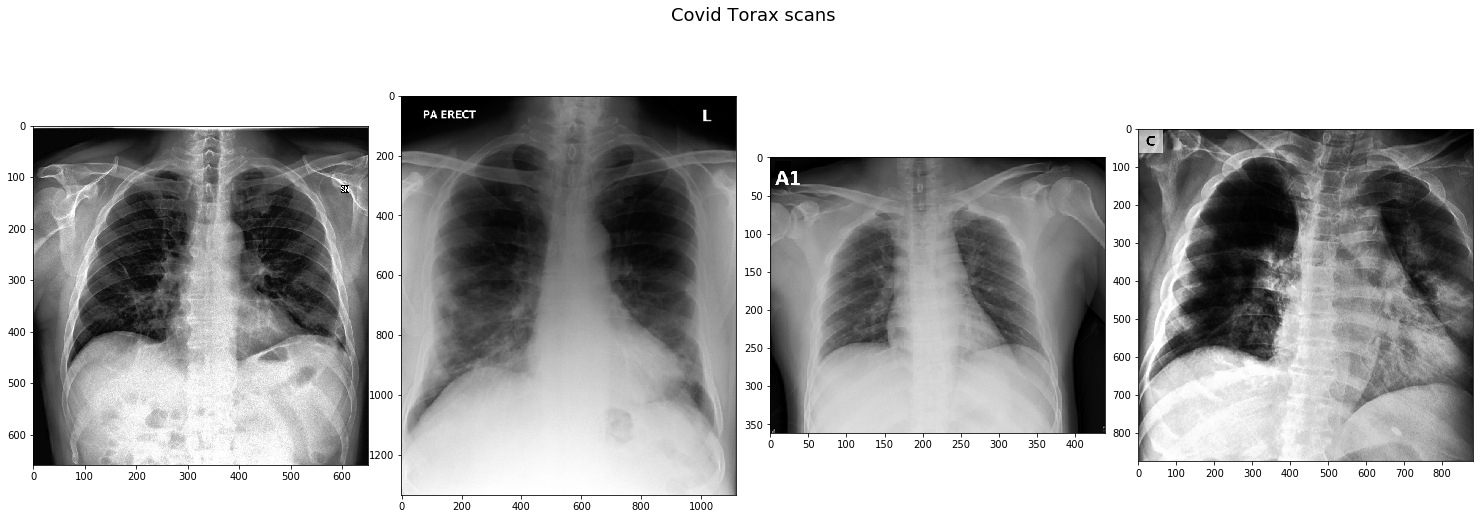

In [23]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Covid Torax scans', y=0.70, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imcor1)
axs[1].imshow(imcor2)
axs[2].imshow(imcor3)
axs[3].imshow(imcor4)
plt.show()

**Neumonia**

In [11]:
imneu1 = cv2.imread('data/Covid19-dataset/train/Viral Pneumonia/01.jpeg', cv2.COLOR_BGR2GRAY)
imneu2 = cv2.imread('data/Covid19-dataset/train/Viral Pneumonia/02.jpeg', cv2.COLOR_BGR2GRAY)
imneu3 = cv2.imread('data/Covid19-dataset/train/Viral Pneumonia/03.jpeg', cv2.COLOR_BGR2GRAY)
imneu4 = cv2.imread('data/Covid19-dataset/train/Viral Pneumonia/04.jpeg', cv2.COLOR_BGR2GRAY)

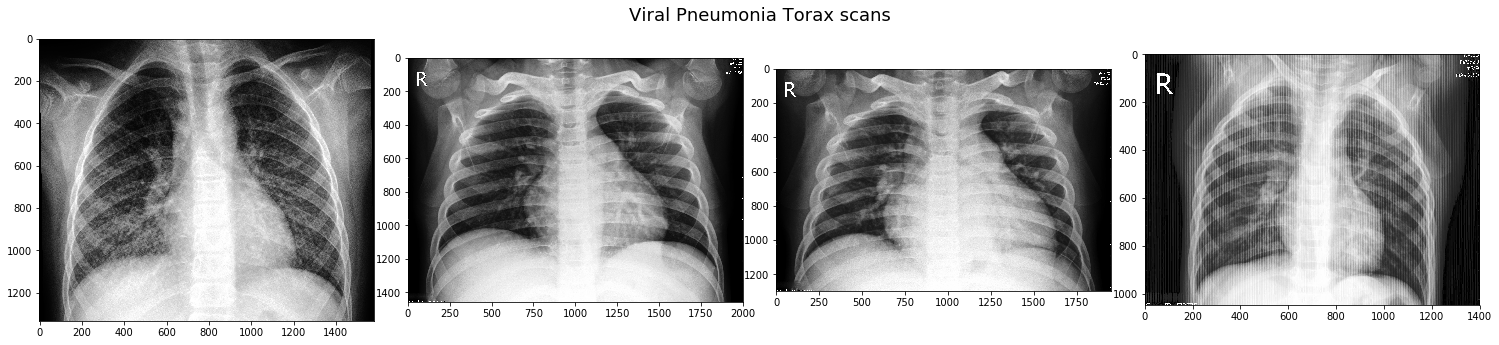

In [12]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Viral Pneumonia Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imneu1)
axs[1].imshow(imneu2)
axs[2].imshow(imneu3)
axs[3].imshow(imneu4)
plt.show()

**Normal**

In [13]:
imnor1 = cv2.imread('data/Covid19-dataset/train/Normal/01.jpeg', cv2.COLOR_BGR2GRAY)
imnor2 = cv2.imread('data/Covid19-dataset/train/Normal/02.jpeg', cv2.COLOR_BGR2GRAY)
imnor3 = cv2.imread('data/Covid19-dataset/train/Normal/03.jpeg', cv2.COLOR_BGR2GRAY)
imnor4 = cv2.imread('data/Covid19-dataset/train/Normal/04.jpeg', cv2.COLOR_BGR2GRAY)

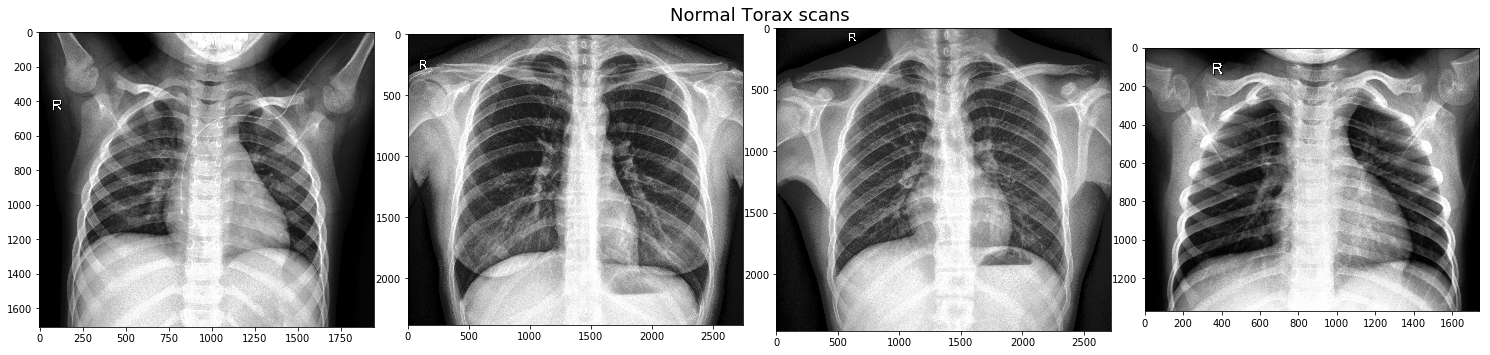

In [14]:
fig, axs = plt.subplots(1,4,figsize=(20,20))
fig.suptitle('Normal Torax scans', y=0.62, fontsize=18)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)
axs[0].imshow(imnor1)
axs[1].imshow(imnor2)
axs[2].imshow(imnor3)
axs[3].imshow(imnor4)
plt.show()

## Parametros de imagen ajustados

Analisis segun las siguientes condiciones:
    
    * dimesiones 100 x 100 (10000 pixeles).
    * en escala de grises

In [33]:
imgtest = cv2.imread('data/Covid19-dataset_completo/photos2/Covid/01.jpeg', cv2.IMREAD_COLOR)

In [34]:
imgtest = cv2.cvtColor(imgtest, cv2.COLOR_BGR2GRAY)

In [35]:
imgtest = cv2.resize(imgtest, (100,100))

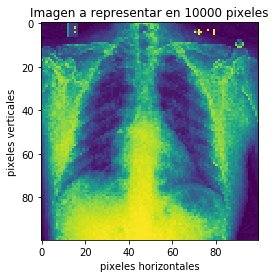

In [36]:
plt.imshow(imgtest)
plt.xlabel('pixeles horizontales')
plt.ylabel('pixeles verticales')
plt.title('Imagen a representar en 10000 pixeles')
plt.show()

In [37]:
imgtest.shape

(100, 100)

In [38]:
imgtest.flatten().shape

(10000,)

In [39]:
def new_dataset(dataset_path):
    '''
    creacion de nuevo dataset a partir de repositorio de imagenes
    dataset_path: ruta absoluta donde se encuentran las imagenes, test o train
    salida: tupla con:
        * matriz de dos dimensiones con mapa de bits de cada imagen (cada registro o lista de una dimension es una imagen) - Feature
        * lista de una dimension con valores numericos que representan la clase a la que pertenece la imagen - Target
        * lista de una dimension con las etiquetas de clase a la que pertenece cada imagen
    '''
    imgs_label = []
    imgs = []
    for pathlabel in os.listdir(dataset_path):
        label = os.path.join(dataset_path, pathlabel)
        for file in os.listdir(label):
            if re.search(pat, file) is not None:
                img = cv2.imread(os.path.join(label, file), cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100,100))
                img = img.flatten()
                imgs.append(img)
                imgs_label.append(pathlabel)
                
    label_to_id_dict = {v:i for i,v in enumerate(np.unique(imgs_label))}
    label_ids = np.array([label_to_id_dict[x] for x in imgs_label])
    
    return np.array(imgs), label_ids, np.array(imgs_label)

**Creacion de variable target**

**Features**

In [22]:
train1_X, train1_y, train1_labels = new_dataset(photos1_dataset_path)
train2_X, train2_y, train2_labels = new_dataset(photos2_dataset_path)
train3_X, train3_y, train3_labels = new_dataset(photos3_dataset_path)

In [23]:
train_X

array([[ 16,  15,  14, ...,  12,  14,  15],
       [131, 126, 129, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  2,   1,   1, ...,   1,   0,   2],
       [  2,   0,   0, ...,   0,   0,   1],
       [ 11,  11,   9, ..., 117,  97,  86]], dtype=uint8)

In [24]:
train_labels

array(['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia',
     

In [25]:
train_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
test_X.shape, test_y.shape, train_X.shape, train_y.shape

((66, 10000), (66,), (251, 10000), (251,))

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [88]:
# Instanciamos el modelo con su configuración por defecto
knn = KNeighborsClassifier()

In [29]:
# Ajustamos a los datos de entrenamiento
knn.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [30]:
# Predecimos etiquetas para los datos de test
y_pred = knn.predict(test_X)

In [31]:
# Evaluamos el accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy_score(test_y, y_pred).round(2)

0.79

In [32]:
y_pred

array([1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [33]:
test_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

---

## Features y target como objetos de pandas

### Preparacion del dataset

Unificacion de set de train y testing para aplicar una estrategia de separacion a traves de los metodos de scikit learn. Se busca mantener la proporcionalidad de la clases de la variable target.

In [40]:
photos1_X, photos1_y, photos1_labels = new_dataset(photos1_dataset_path)
photos2_X, photos2_y, photos2_labels = new_dataset(photos2_dataset_path)
photos3_X, photos3_y, photos3_labels = new_dataset(photos3_dataset_path)

In [55]:
numpy_append = np.append(photos1_X, photos2_X, axis=0)
data_features = pd.DataFrame(np.append(numpy_append, photos3_X, axis=0))

In [56]:
data_features

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,57,65,68,64,65,69,70,63,56,52,...,123,116,61,24,8,2,0,0,0,0
1,20,30,38,85,110,116,145,116,122,115,...,121,107,80,151,129,77,12,0,0,0
2,0,0,0,139,143,196,178,172,169,168,...,48,27,2,7,13,21,21,0,0,0
3,0,0,0,42,32,34,44,46,53,182,...,135,102,175,178,163,252,255,0,0,0
4,0,0,0,0,99,109,115,119,127,174,...,34,23,2,5,8,9,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,16,9,6,5,4,3,9,12,12,16,...,108,101,89,72,66,57,39,5,3,16
666,7,8,8,8,7,7,7,6,6,5,...,36,28,2,2,5,8,10,11,12,30
667,46,32,27,253,225,237,238,96,41,42,...,76,56,28,30,33,36,37,38,44,52
668,1,0,0,0,0,1,1,1,1,1,...,177,169,132,63,16,2,0,0,0,1


In [57]:
numpy_append = np.append(photos1_y, photos2_y, axis=0)
data_target = pd.Series(np.append(numpy_append, photos3_y, axis=0))

In [58]:
data_features.shape, data_target.shape

((670, 10000), (670,))

**Armado de sets de test y train**

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, stratify=data_target, random_state=0)

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((502, 10000), (168, 10000), (502,), (168,))

In [61]:
y_train.value_counts(normalize=True)

1    0.344622
0    0.342629
2    0.312749
dtype: float64

In [62]:
y_test.value_counts(normalize=True)

1    0.345238
0    0.339286
2    0.315476
dtype: float64

---

### Lo mismo pero estandarizando las variables

In [63]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [64]:
X_train

array([[-0.66690934, -0.71881193, -0.76340804, ...,  1.15605401,
         1.12987377,  0.96064689],
       [-0.40201509, -0.45415297, -0.49679943, ..., -0.35070468,
        -0.32447657, -0.31378424],
       [-0.34525204, -0.3407277 , -0.42062554, ..., -0.35070468,
        -0.2543874 , -0.20454728],
       ...,
       [ 0.79000903,  0.68009972,  0.70293933, ...,  1.69780994,
         1.79572091,  1.7070994 ],
       [-0.49662018, -0.54867402, -0.59201679, ..., -0.41842417,
        -0.39456574, -0.40481503],
       [-0.59122527,  2.62723349, -0.76340804, ...,  1.68088007,
         2.3213897 ,  0.57831755]])

In [65]:
# Verificamos que las variables ahora tengan media 0 y desvío 1.
print('Medias:', np.mean(X_train, axis=0).round(2))
print('Desvio:', np.std(X_train, axis=0).round(2))

Medias: [ 0. -0. -0. ... -0. -0.  0.]
Desvio: [1. 1. 1. ... 1. 1. 1.]


In [66]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [67]:
# Calculamos nuevamente los scores de cross validation,
# pero esta vez sobre los features estandarizados:

scores_para_df_standard = []

for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    scores_para_df_standard.append(dict_row_score)

In [68]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_knn_scores_standard = pd.DataFrame(scores_para_df_standard)
df_knn_scores_standard.sort_values(by='score_medio', ascending=False).head(5)

,score_medio,score_std,n_neighbors
8,0.868535,0.029180,9
2,0.866475,0.042720,3
0,0.864535,0.035910,1
9,0.860594,0.027361,10
10,0.860554,0.017813,11


In [69]:
# Armamos nuevamente los límites para graficar
df_knn_scores_standard['limite_superior'] = df_knn_scores_standard['score_medio'] + df_knn_scores_standard['score_std']
df_knn_scores_standard['limite_inferior'] = df_knn_scores_standard['score_medio'] - df_knn_scores_standard['score_std']
df_knn_scores_standard.sort_values(by='score_medio', ascending=False).head(5)

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
8,0.868535,0.029180,9,0.897714,0.839355
2,0.866475,0.042720,3,0.909196,0.823755
0,0.864535,0.035910,1,0.900445,0.828625
9,0.860594,0.027361,10,0.887955,0.833233
10,0.860554,0.017813,11,0.878368,0.842741


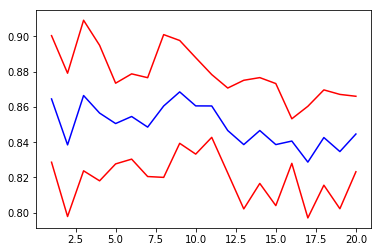

In [70]:
# Graficamos los resultados
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['limite_inferior'], color='r')
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['score_medio'], color='b')
plt.plot(df_knn_scores_standard['n_neighbors'], df_knn_scores_standard['limite_superior'], color='r');

In [71]:
# Identificamos el score máximo
df_knn_scores_standard.loc[df_knn_scores_standard.score_medio == df_knn_scores_standard.score_medio.max()]

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
8,0.868535,0.02918,9,0.897714,0.839355


Si bien el valor de _k_ óptimo vuelve a ser el mismo que antes, notamos que el _score_ promedio de la validación cruzada es varios puntos más alto que el que habíamos alcanzado sin la estandarización de las variables.

Ahora que decidimos cuál es el mejor preprocesamiento y el mejor valor posible para el hiperparámetro `n_neighbors`, podemos reentrenar el modelo y evaluar los resultados sobre _test_.

In [72]:
# Asignamos el valor del k óptimo a una variable
best_k = df_knn_scores_standard.loc[df_knn_scores_standard.score_medio == df_knn_scores_standard.score_medio.max(), 'n_neighbors'].values[0:2]
best_k

array([9])

In [73]:
# Elegimos el modelo óptimo de acuerdo a las pruebas de cross validation
model = KNeighborsClassifier(n_neighbors=best_k[0])

# Lo ajustamos sobre los datos de entrenamiento
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [76]:
# Evaluamos qué accuracy obtenemos en train
accuracy_score(y_train, model.predict(X_train)).round(2)

0.89

En línea con los resultados que habíamos durante las pruebas de validación cruzada, nuestro KNN está alcanzando un _accuracy score_ del orden del 97% sobre los datos de entrenamiento. Veamos si es capaz de generalizar sobre el conjunto de testeo con una _performance_ similar.

In [77]:
# Lo utilizamos para predecir en test
#X_test = scaler.transform(X_test) # ¡Importantísimo estandarizar también los datos de test con las medias y desvíos aprendidos en train!
y_pred = model.predict(X_test)

In [78]:
# Evaluamos el accuracy del modelo en test
accuracy_score(y_test, y_pred).round(2)

0.88

In [79]:
# Obtenemos la matriz de confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[54,  2,  1],
       [ 4, 45,  9],
       [ 0,  4, 49]])

Matriz de confusión

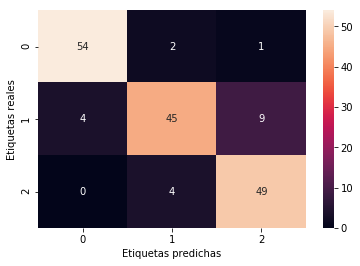

In [80]:
# Graficamos la matriz de confusión para visualizarla mejor
sns.heatmap(cm, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

In [81]:
y_test.shape

(168,)

## Uso de gridseach

Seleccion de parametros del modelo.
Se puede probar otra metrica de evaluacion de ser necesario. Por ejemplo recall o precision

In [85]:
k_range = list(range(1, 31))
weight_opt = ['uniform', 'distance']
metric_opt = ['manhattan', 'minkowski']

Creacion de la grilla de hiperparametros del modelo

In [86]:
param_grid = dict(n_neighbors=k_range, weights=weight_opt, metric=metric_opt)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'minkowski']}


In [ ]:
grid = GridSearchCV(knn, param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

In [63]:
pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.062088,0.003551,0.177067,0.014800,manhattan,2,uniform,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.979167,0.875000,0.893617,0.914894,0.978723,0.928280,0.043252,1
0,0.055961,0.005416,0.166431,0.016317,manhattan,1,uniform,"{'metric': 'manhattan', 'n_neighbors': 1, 'wei...",0.958333,0.916667,0.936170,0.872340,0.957447,0.928191,0.031875,2
1,0.063598,0.002235,0.184138,0.014405,manhattan,1,distance,"{'metric': 'manhattan', 'n_neighbors': 1, 'wei...",0.958333,0.916667,0.936170,0.872340,0.957447,0.928191,0.031875,2
3,0.056824,0.004189,0.165820,0.010260,manhattan,2,distance,"{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",0.958333,0.916667,0.936170,0.872340,0.957447,0.928191,0.031875,2
6,0.062737,0.002617,0.181493,0.007214,manhattan,4,uniform,"{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.958333,0.937500,0.872340,0.872340,0.914894,0.911082,0.034488,5


In [64]:
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
0.9282801418439716
{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}


In [65]:
y_pred_grid = grid.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.89      0.74      0.81        23
           2       0.76      0.83      0.79        23

    accuracy                           0.85        80
   macro avg       0.85      0.84      0.84        80
weighted avg       0.85      0.85      0.85        80



In [67]:
confusion = confusion_matrix(y_test, y_pred_grid)
print(confusion)

[[32  1  1]
 [ 1 17  5]
 [ 3  1 19]]
